<a href="https://colab.research.google.com/github/Asigen93/DeepLearning_Tugas2/blob/main/klasifikasi_gorengan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KLASIFIKASI GORENGAN (BAKWAN, LUMPIA, TAHU, TEMPE)

#Import Necessary Libraries

In [26]:
!pip install keras_preprocessing

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling
from PIL import Image

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Load and Transform Data

In [28]:
# Parameter dasar
BATCH_SIZE = 32
TARGET_SIZE = (128, 128)

# Walk through each directory
from google.colab import drive
drive.mount('/content/drive')

# Path dataset
dataset = "/content/drive/MyDrive/Gorengan"

# Melihat struktur folder dan jumlah file di tiap kelas
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ada 4 folder dan 0 file di direktori: /content/drive/MyDrive/Gorengan
Ada 0 folder dan 300 file di direktori: /content/drive/MyDrive/Gorengan/Lumpia
Ada 0 folder dan 300 file di direktori: /content/drive/MyDrive/Gorengan/Tahu
Ada 0 folder dan 300 file di direktori: /content/drive/MyDrive/Gorengan/Tempe
Ada 0 folder dan 300 file di direktori: /content/drive/MyDrive/Gorengan/Bakwan


#Placing Data into a DataFrame

In [29]:
image_dir = Path(dataset)

# Dapatkan jalur file dan label
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Gabungkan jalur file dan label
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-30-7f2a8ae770a4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


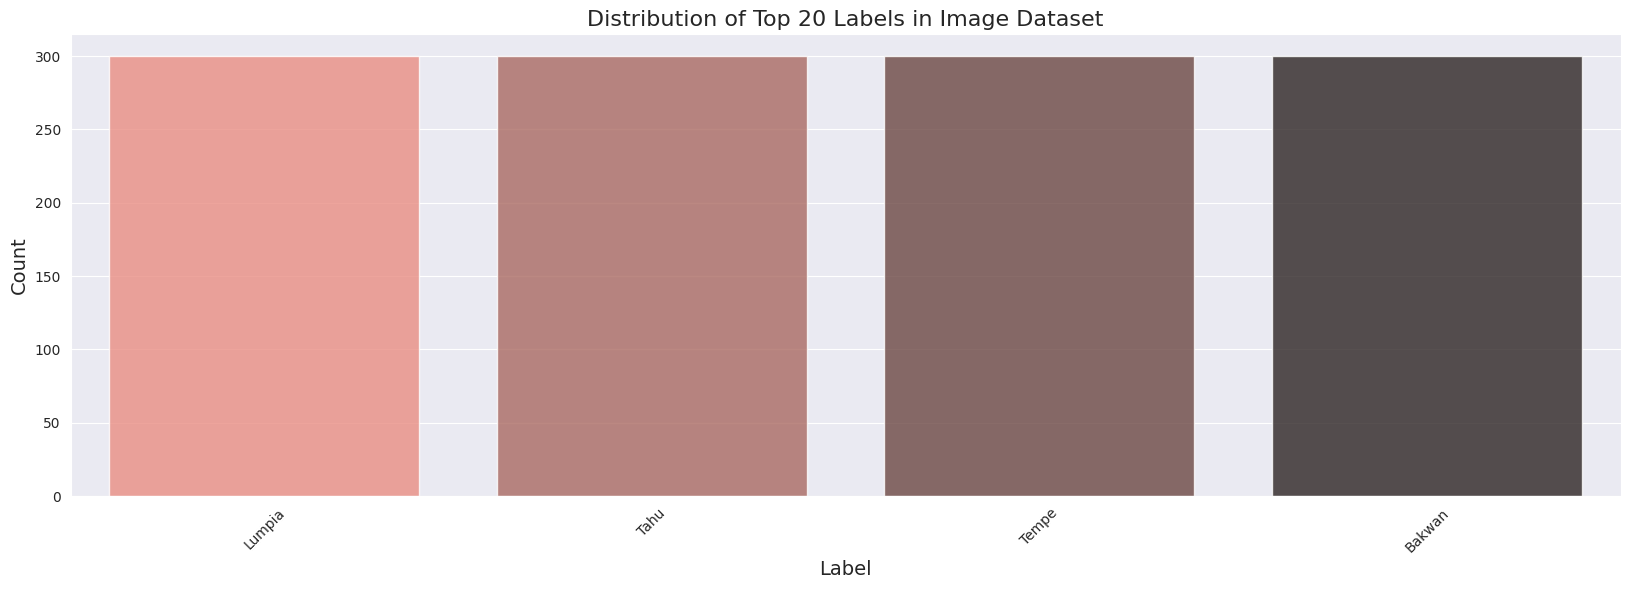

In [30]:
# Dapatkan 20 label teratas
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

#Visualizing Images from the Dataset

<ipython-input-31-bbcfa8ec6a1b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)


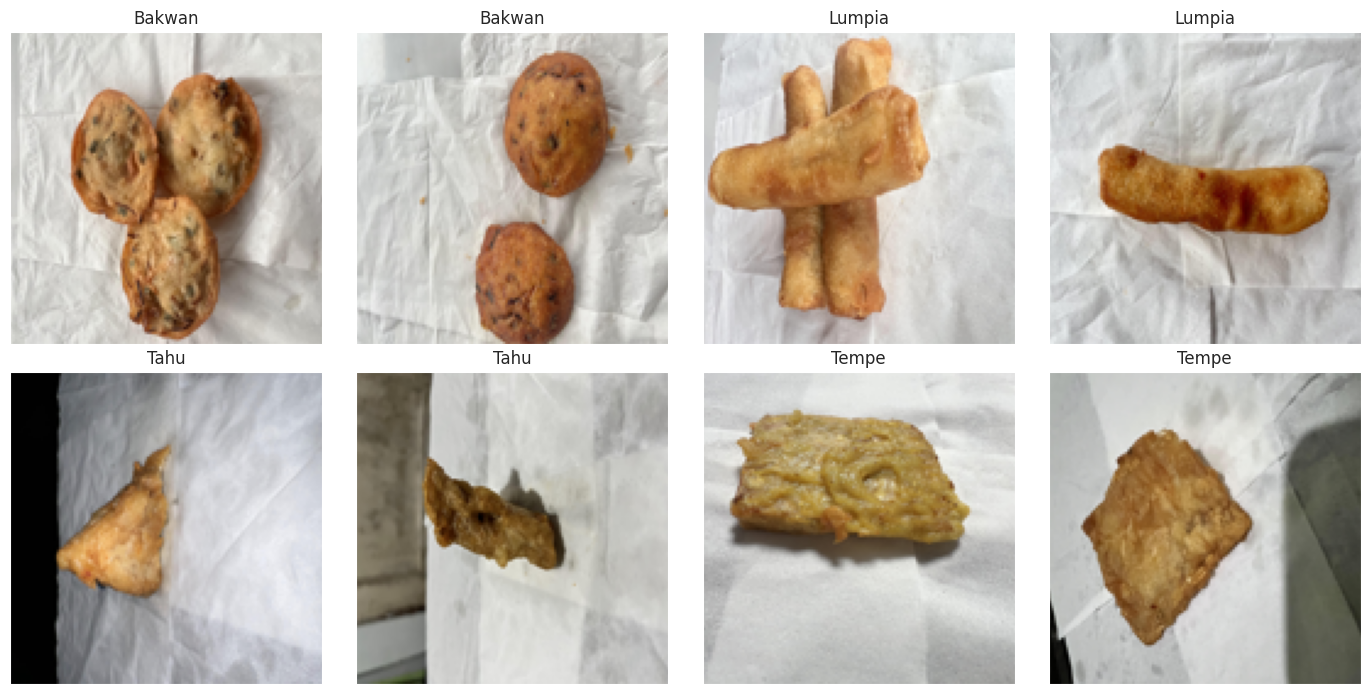

In [31]:
# Ambil 2 gambar acak dari tiap kelas
sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)

# Plot gambar-gambar
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = sample_df.Filepath[i]
    label = sample_df.Label[i]

    # Membaca gambar dan mengubah ukurannya menjadi persegi (128x128 misalnya)
    img = Image.open(img_path)
    img_resized = img.resize((128, 128))

    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.show()

#Computing Error Rate Analysis

In [32]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Membaaca gambar yang terkompres
    compressed_img = cv2.imread(temp_filename)

    # Dapatkan perbedaan absolut antara img1 dan img2 dan kalikan dengan skala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    # Pilih gambar acak dari folder
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

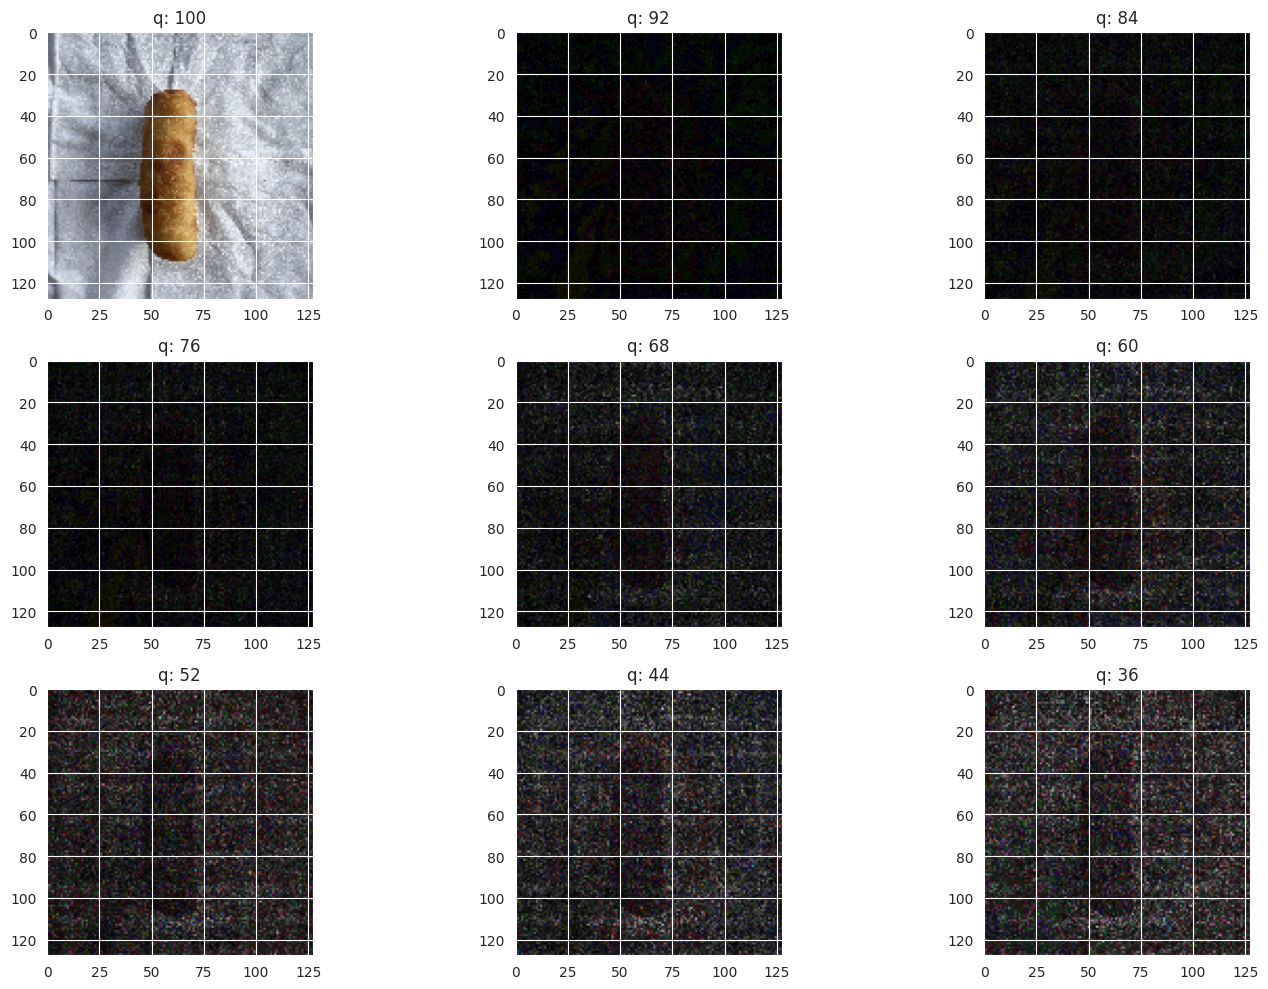

In [33]:
# Lihat sampel acak dari kumpulan data dan terapkan ELA
sample_class = 'Lumpia'
dataset_path = '/content/drive/MyDrive/Gorengan'
p = random_sample(f'{dataset_path}/{sample_class}')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# Inisialisasi parameter
init_val = 100
columns = 3
rows = 3

# Membuat figure untuk plot
fig = plt.figure(figsize=(15, 10))

for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8  # Menurunkan kualitas kompresi untuk setiap gambar
    img = compute_ela_cv(path=p, quality=quality)

    if i == 1:
        img = orig.copy()  # Gambar asli di posisi pertama

    # Mengubah ukuran gambar menjadi persegi
    img_resized = cv2.resize(img, (128, 128))  # Ganti 128 dengan ukuran yang diinginkan

    # Menambahkan gambar yang telah diresize ke dalam subplot
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img_resized)

plt.tight_layout()
plt.show()

#Data Preprocessing

**Training 70%**

**Validasi 25%**

**Test 5%**

In [34]:
# Split test set terlebih dahulu (5%)
train_val_df, test_df = train_test_split(
    image_df,
    test_size=0.05,
    shuffle=True,
    random_state=42,
    stratify=image_df['Label']
)

# Dari sisa 95%, ambil 25% dari total dataset sebagai validasi
# 25% dari total berarti 25/95 ≈ 0.263 dari sisa train_val_df
val_size = 25 / 95  # ≈ 0.263

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    shuffle=True,
    random_state=42,
    stratify=train_val_df['Label']
)

# Konfirmasi ukuran
print(f"Jumlah data latih: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data uji: {len(test_df)}")

Jumlah data latih: 840
Jumlah data validasi: 300
Jumlah data uji: 60


In [36]:
# Membuat generator untuk data latih, validasi, dan uji
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [37]:
# Membuat data generator untuk training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk validasi
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 840 validated image filenames belonging to 4 classes.
Found 300 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.


In [38]:
# Menghitung jumlah gambar per kelas pada data latih
train_class_counts = train_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data latih:")
print(train_class_counts)

# Menghitung jumlah gambar per kelas pada data validasi
val_class_counts = val_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data validasi:")
print(val_class_counts)

# Menghitung jumlah gambar per kelas pada data pengujian
test_class_counts = test_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data pengujian:")
print(test_class_counts)

Jumlah gambar per kelas pada data latih:
Label
Bakwan    210
Lumpia    210
Tahu      210
Tempe     210
dtype: int64
Jumlah gambar per kelas pada data validasi:
Label
Bakwan    75
Lumpia    75
Tahu      75
Tempe     75
dtype: int64
Jumlah gambar per kelas pada data pengujian:
Label
Bakwan    15
Lumpia    15
Tahu      15
Tempe     15
dtype: int64


In [39]:
# Langkah Augmentasi Data
augment = tf.keras.Sequential([
    layers.Resizing(128, 128),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

#Training the Model

In [40]:
# Muat MobileNetV2 sebagai model dasar
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [41]:
# Buat panggilan balik titik pemeriksaan
checkpoint_path = "alat_pembersih_rumah.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Siapkan panggilan balik EarlyStopping untuk menghentikan pelatihan jika val_loss model tidak membaik selama 5 epoch
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [42]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(64, activation='relu')(pretrained_model.output)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "alat_pembersih_rumah"),
        checkpoint_callback,
        reduce_lr
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.2783 - loss: 2.8593 - val_accuracy: 0.3900 - val_loss: 1.3407 - learning_rate: 5.0000e-05
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.2901 - loss: 2.2514 - val_accuracy: 0.5233 - val_loss: 1.1723 - learning_rate: 5.0000e-05
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.2797 - loss: 1.8983 - val_accuracy: 0.5900 - val_loss: 1.0964 - learning_rate: 5.0000e-05
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.3529 - loss: 1.5377 - val_accuracy: 0.6300 - val_loss: 1.0479 - learning_rate: 5.0000e-05
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.3953 - loss: 1.4902 - val_accuracy: 0.7100 - val_loss: 0.9968 - learning_rate: 5.0000e-05
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.4524 - loss: 1.2478 - val_accuracy: 0.7600 - val_loss: 0.9408 - learning_rate: 5.0000e-05
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.4730 

#Model Evaluation

In [43]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.19088
Test Accuracy: 95.00%


#Visualizing Loss Curves

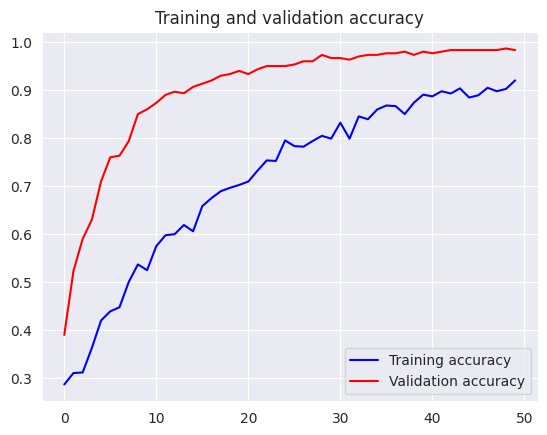

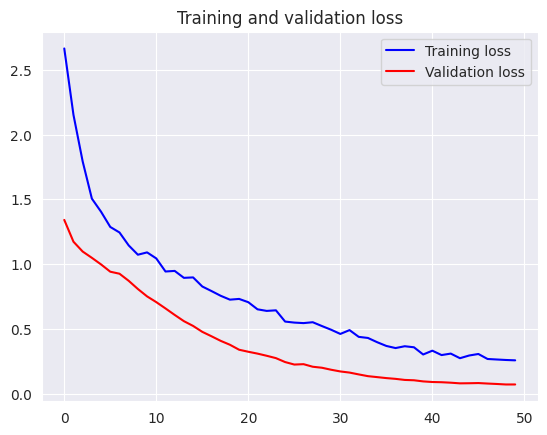

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

#Making Predictions on the Test Data

In [45]:
# Predict label test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Petakan label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


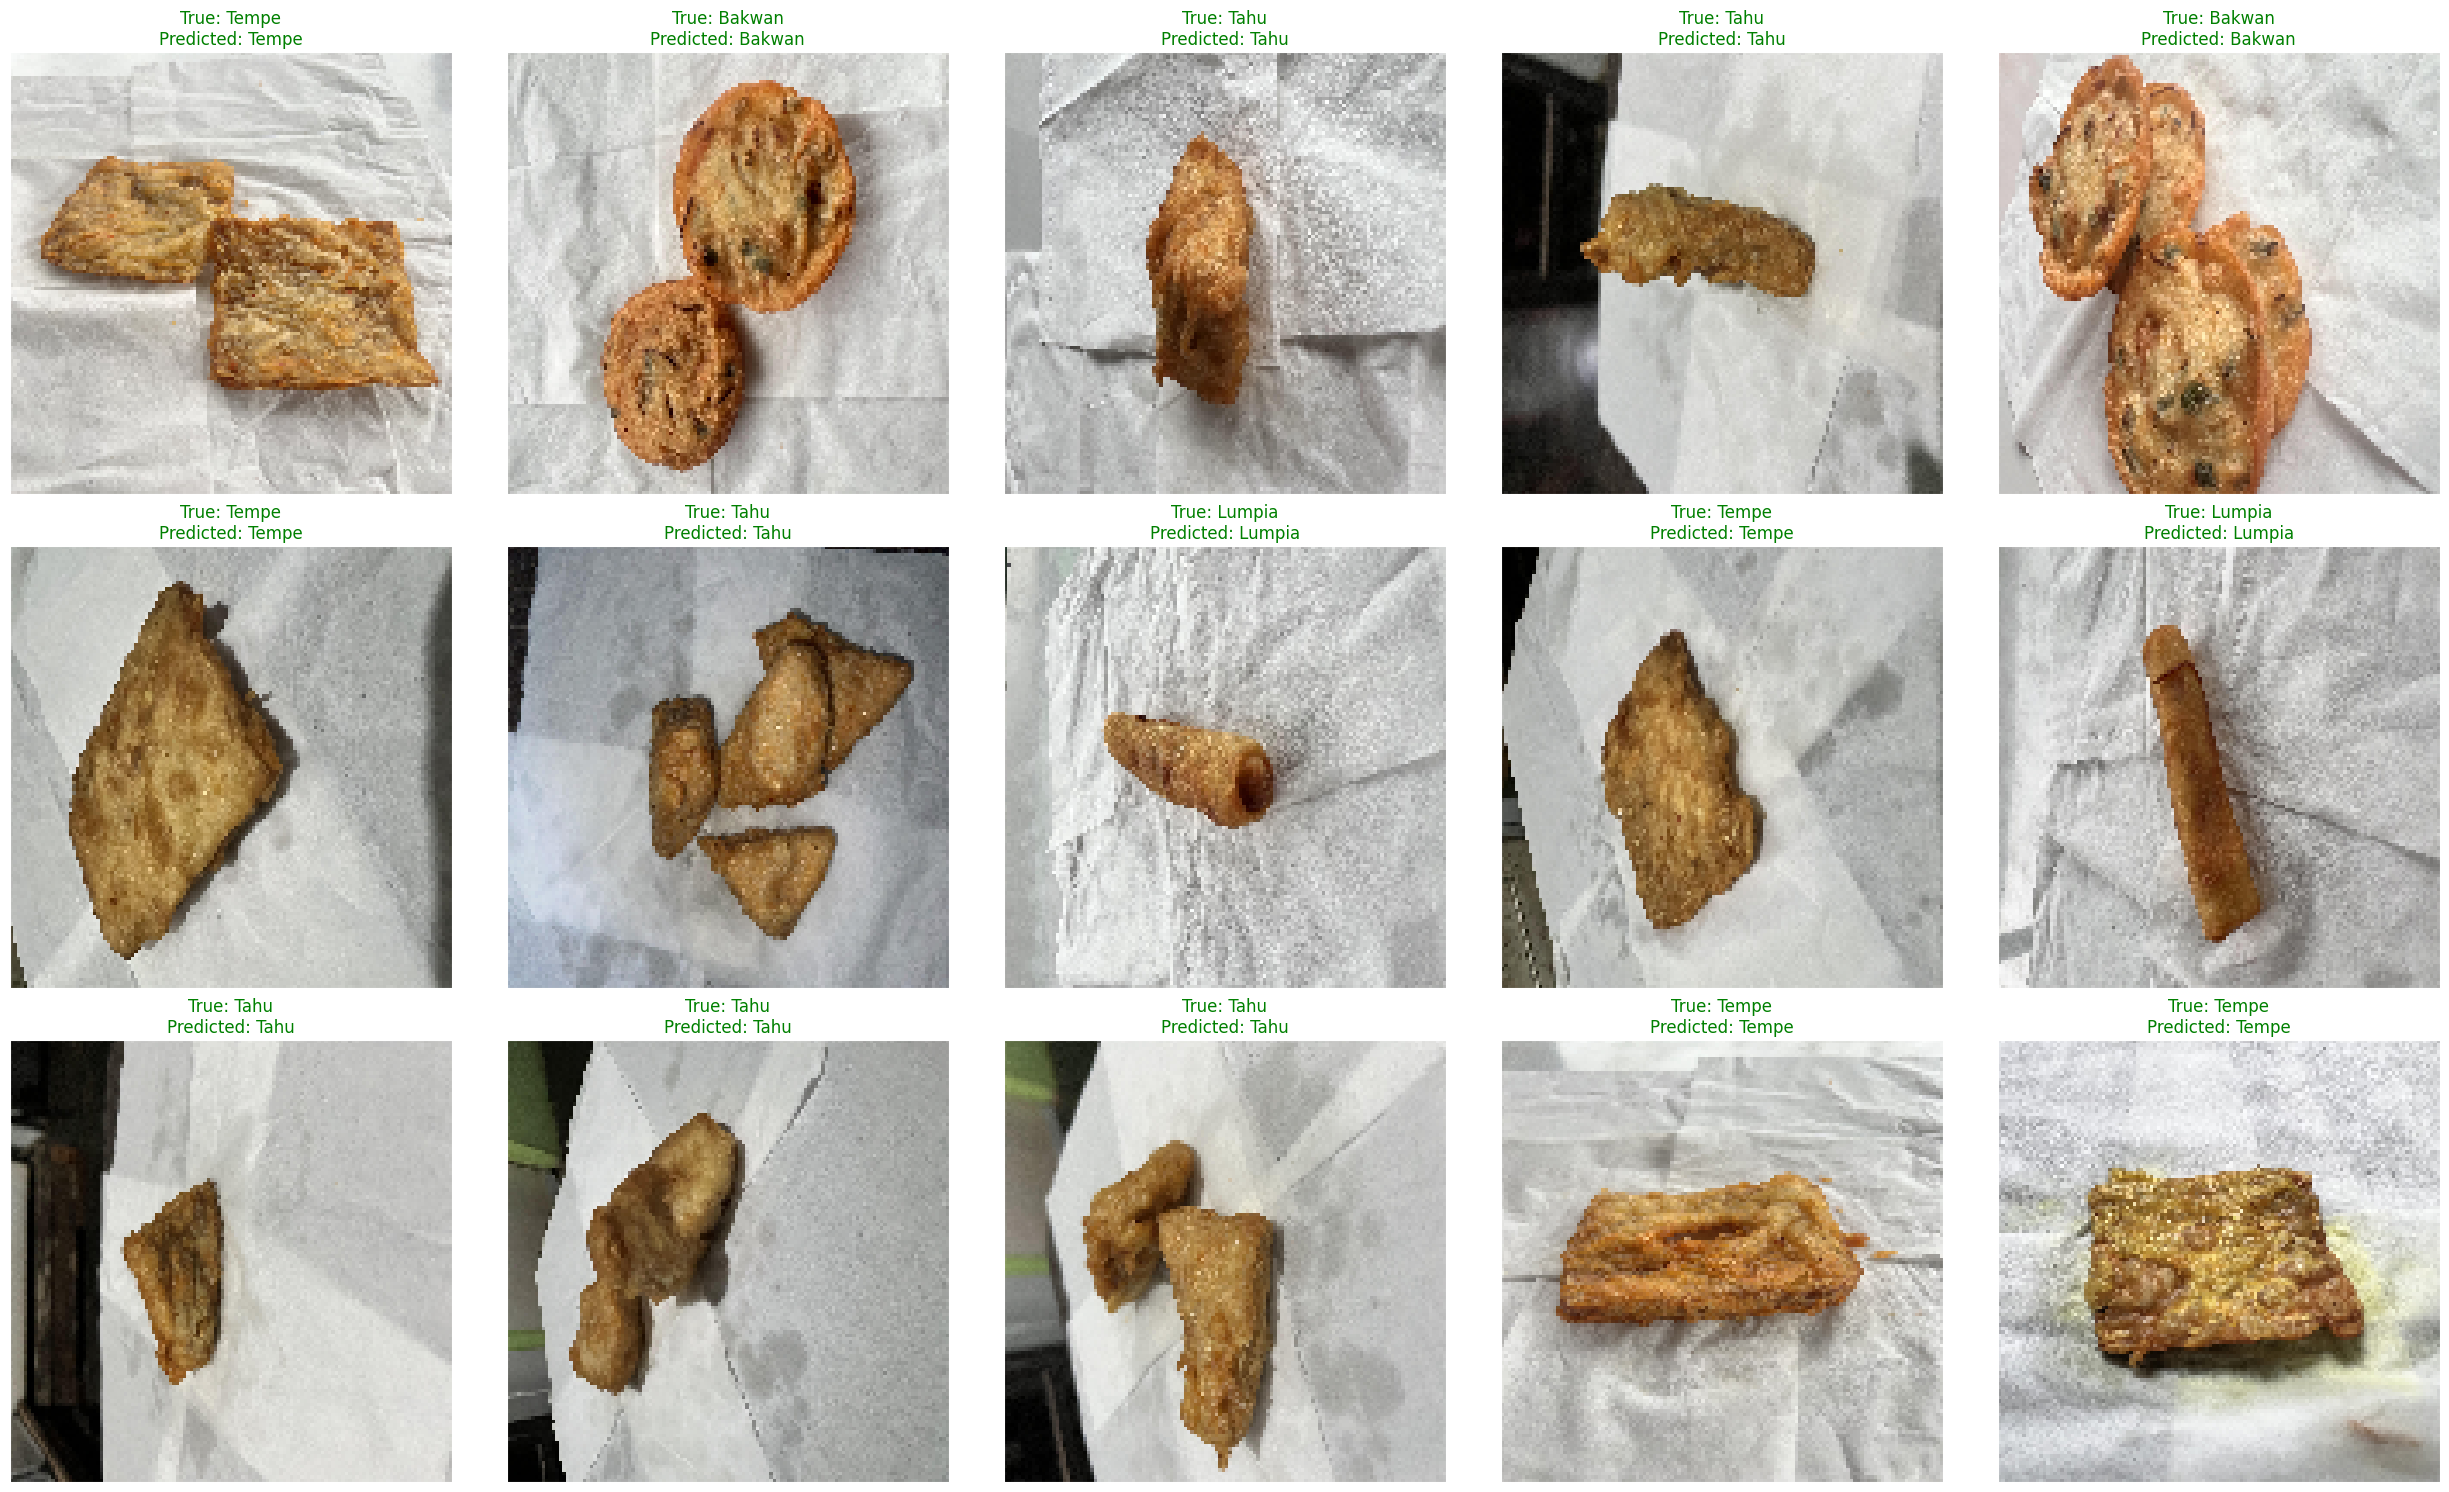

In [46]:
# Menampilkan 25 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (128, 128)

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    img_resized = cv2.resize(img, resize_dim)
    ax.imshow(img_resized)

    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

#Plotting the Classification Reports and Confusion Matrix

In [47]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Bakwan       1.00      1.00      1.00        15
      Lumpia       0.93      0.93      0.93        15
        Tahu       1.00      0.87      0.93        15
       Tempe       0.88      1.00      0.94        15

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [48]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
Bakwan         1.000000  1.000000  1.000000    15.00
Lumpia         0.933333  0.933333  0.933333    15.00
Tahu           1.000000  0.866667  0.928571    15.00
Tempe          0.882353  1.000000  0.937500    15.00
accuracy       0.950000  0.950000  0.950000     0.95
macro avg      0.953922  0.950000  0.949851    60.00
weighted avg   0.953922  0.950000  0.949851    60.00

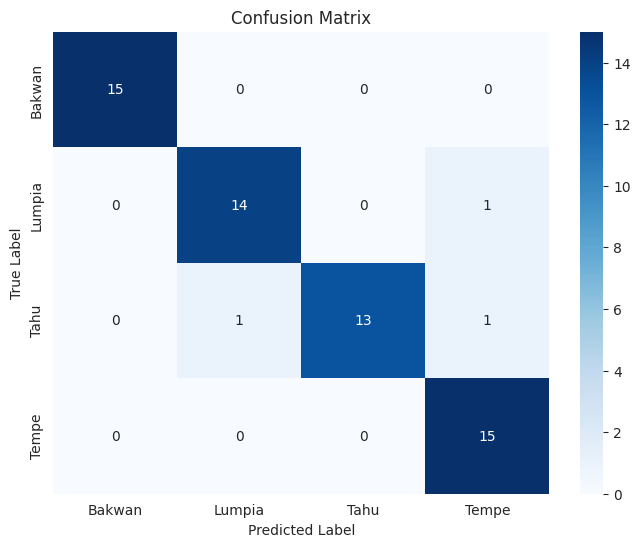

In [49]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Grad-CAM Visualization

In [50]:
def get_img_array(img_path, size):
    # Memuat gambar dan mengubah ukuran gambar sesuai dengan ukuran yang ditentukan
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Menambahkan dimensi untuk mengubah array menjadi "batch" dengan ukuran "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Membuat model yang memetakan gambar input ke aktivasi dari layer konvolusi terakhir
    # serta output prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Menghitung gradien dari kelas yang diprediksi untuk gambar input
    # terhadap aktivasi layer konvolusi terakhir
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # Ini adalah gradien dari neuron output (kelas yang dipilih atau tertinggi)
    # terhadap feature map output dari layer konvolusi terakhir
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Ini adalah vektor dimana setiap entri adalah intensitas rata-rata dari gradien
    # di setiap channel feature map tertentu
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Mengalikan setiap channel dalam array feature map
    # dengan "seberapa penting channel ini" terhadap kelas yang diprediksi tertinggi
    # kemudian menjumlahkan semua channel untuk mendapatkan heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## Untuk tujuan visualisasi, kita juga akan menormalisasi heatmap antara 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Memuat gambar asli
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Menyusun ulang heatmap ke rentang 0-255
    heatmap = np.uint8(255 * heatmap)

    # Menggunakan colormap 'jet' untuk mewarnai heatmap
    jet = cm.get_cmap("jet")

    # Mengambil nilai RGB dari colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Membuat gambar dengan heatmap yang diberi warna RGB
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Menggabungkan heatmap dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Menyimpan gambar yang sudah digabungkan
    superimposed_img.save(cam_path)

    # Menampilkan Grad CAM
    # display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (128,128, 3)

# Menghapus softmax dari layer terakhir
model.layers[-1].activation = None

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_169']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
<ipython-input-50-ac68fe291b88>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


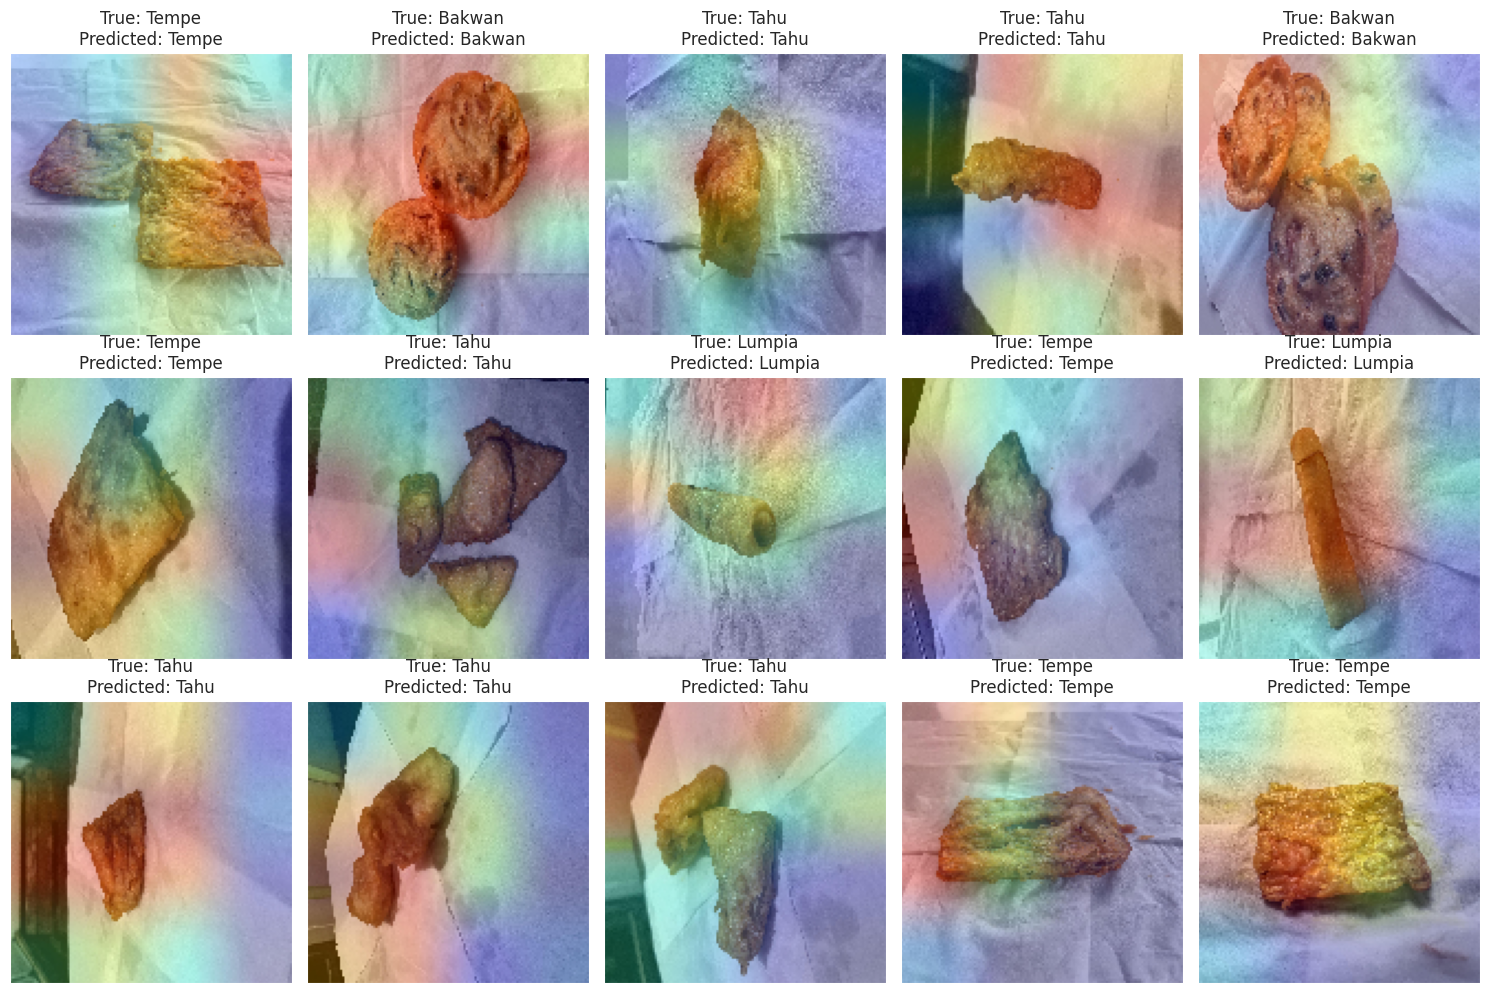

In [51]:
import matplotlib.cm as cm
# Tampilkan bagian gambar yang digunakan oleh jaringan saraf untuk mengklasifikasikan gambar
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (128, 128)

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)

    img_resized = cv2.resize(plt.imread(cam_path), resize_dim)

    ax.imshow(img_resized)
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")

plt.tight_layout()
plt.show()